In [ ]:
!pip install transformers sentencepiece datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.6 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
import random
sns.set()

/usr/local/lib/python3.10/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_repo = 'google/mt5-small'
model_path = '/content/gdrive/My Drive/mt5_translation.pt'
max_seq_len = 20

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Model description: https://huggingface.co/google/mt5-small
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()
token_ids = tokenizer.encode(
    '<hi_en> This will be translated to Hinglish! (hopefully)',
    return_tensors='pt')
print(token_ids)

tensor([[  1042,   1500,    290,    278,    669,   1494,    898,    390,  37194,
            285,    288, 140726,  45595,    309,    274, 116024,  11994,    271,
              1]])


In [ ]:
token_ids = token_ids.to('cuda')
model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[     0, 250099,      1]], device='cuda:0')
<pad> <extra_id_0></s>


In [ ]:
example_input_str = '<hi_ng> This is just a test nbuig.'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

Input IDs: tensor([[1042, 1500,  290,  370,  669, 1494,  339, 1627,  259,  262, 2978,  259,
          272, 1982, 1315,  260,    1]])


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Tokens: ['▁<', 'hi', '_', 'ng', '>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>']


In [ ]:
# Source: 'https://huggingface.co/datasets/findnitai/english-to-hinglish'
dataset = load_dataset("findnitai/english-to-hinglish")


from sklearn.model_selection import train_test_split
data = dataset['train']

# Choose only 300 samples for training
train_subset = data[:300]


# Split the data into training and testing sets
train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=42)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# train_data now contains the training subset, and test_data contains the testing subset

LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'hi_ng': '<hi_ng>'
}

# Access the first example in the dataset
first_example = train_dataset['translation'][0]

# Access the English and Hinglish translations for the first example
english_translation = first_example['en']
hinglish_translation = first_example['hi_ng']

# Print the translations
print("English Translation:", english_translation)
print("Hinglish Translation:", hinglish_translation)

English Translation: has my timer started ?
Hinglish Translation: mera timer shuru hoga ?


In [ ]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tensor([[250100,   1494,    339,   1627,    259,    262,   2978,    259,    272,
           1982,   1315,    260,      1,      0,      0,      0,      0,      0,
              0,      0]])


In [ ]:

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

['<hi_ng>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


In [ ]:
import torch
import numpy as np

def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map):
    target_lang_token = lang_token_map[target_lang]

    # Tokenize and add special tokens
    input_ids = tokenizer.encode_plus(
        text=target_lang_token + text,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=seq_len).to('cuda')

    return input_ids['input_ids'][0]

def encode_target_str(text, tokenizer, seq_len, lang_token_map):
    target_lang_token = lang_token_map['hi_ng']  # Assuming the target language is 'hi_ng'

    # Tokenize and add special tokens
    token_ids = tokenizer.encode_plus(
        text=target_lang_token + text,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=seq_len).to('cuda')

    target_token_ids = token_ids['input_ids'][0]

    return target_token_ids

# Replace the old encode_target_str function with the updated version


def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
    # Choose a random 2 languages for input and output
    langs = list(lang_token_map.keys())
    input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

    # Get the translations for the batch
    input_text = translations[input_lang]
    target_text = translations[target_lang]

    if input_text is None or target_text is None:
        return None

    input_token_ids = encode_input_str(
        input_text, target_lang, tokenizer, seq_len, lang_token_map)

    target_token_ids = encode_target_str(
        target_text, tokenizer, seq_len, lang_token_map)

    return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer, max_seq_len=128):
    inputs = []
    targets = []
    for translation_set in batch:
        formatted_data = format_translation_data(
            translation_set, lang_token_map, tokenizer, max_seq_len)

        if formatted_data is None:
            continue

        # Unpack the formatted data
        input_ids, target_ids = formatted_data

        # Move tensors to the GPU
        input_ids = input_ids.to('cuda')
        target_ids = target_ids.to('cuda')

        # Resize target_ids to have max_seq_len length using padding
        padding_length = max_seq_len - len(target_ids)
        pad_token_ids = [tokenizer.pad_token_id] * padding_length
        target_ids = torch.cat((target_ids[:max_seq_len], torch.tensor(pad_token_ids).to('cuda')))

        inputs.append(input_ids)
        targets.append(target_ids)

    batch_input_ids = torch.cat(inputs)
    batch_target_ids = torch.cat(targets)

    return batch_input_ids, batch_target_ids




def get_data_generator(data, lang_token_map, tokenizer, batch_size=8, max_seq_len=128):
    batch = []
    for example in data:
        batch.append(example)
        if len(batch) >= batch_size:
            yield transform_batch(batch, lang_token_map, tokenizer, max_seq_len)
            batch = []

    if len(batch) > 0:
        yield transform_batch(batch, lang_token_map, tokenizer, max_seq_len)

In [ ]:
# Testing `format_translation_data`
in_ids, out_ids = format_translation_data(
    train_dataset['translation'][0], LANG_TOKEN_MAPPING, tokenizer)

print('Input Text:', ' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print('Output Text:', ' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

Input Text: <hi_ng> ▁has ▁my ▁timer ▁ started ▁ ? </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Output Text: <hi_ng> ▁mera ▁timer ▁ s huru ▁hoga ▁ ? </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

In [ ]:
# Testing data generator
data_gen = get_data_generator(train_dataset['translation'], LANG_TOKEN_MAPPING, tokenizer, batch_size=8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

# Access the first example in the 'translation' dataset within train_dataset
first_example = train_dataset['translation'][0]

# Access the English text within the first example
english_text = first_example['en']
print('English text:', english_text)

# Access the translation text within the first example
translation_text = first_example['hi_ng']
print('Translation text:', translation_text)

Input shape: torch.Size([1024])
Output shape: torch.Size([1024])
English text: has my timer started ?
Translation text: mera timer shuru hoga ?


In [ ]:
# Set the training parameters
batch_size = 270
num_epochs = 5
learning_rate = 5e-4
warmup_steps = 50
log_interval = 50

In [ ]:
# Prepare the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=len(train_dataset) // batch_size * num_epochs
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

input_data = data_batch[0]
target_data = data_batch[1]
print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)


Input data shape: torch.Size([1024])
Target data shape: torch.Size([1024])


Epoch 1, Batch 50, Loss: 18.0772
Epoch 1, Batch 100, Loss: 17.9684
Epoch 1, Batch 150, Loss: 17.9841
Epoch 1, Batch 200, Loss: 18.1291
Epoch 1, Batch 250, Loss: 17.9397
Epoch 1, Batch 300, Loss: 18.0184
Epoch 1, Batch 350, Loss: 18.0604
Epoch 1, Batch 400, Loss: 17.9527
Epoch 1, Batch 450, Loss: 17.9364
Epoch 1, Batch 500, Loss: 18.0388
Epoch 1, Batch 550, Loss: 18.0660
Epoch 2, Batch 50, Loss: 18.0797
Epoch 2, Batch 100, Loss: 18.0148
Epoch 2, Batch 150, Loss: 18.0306
Epoch 2, Batch 200, Loss: 18.1252
Epoch 2, Batch 250, Loss: 18.0112
Epoch 2, Batch 300, Loss: 18.0527
Epoch 2, Batch 350, Loss: 18.0122
Epoch 2, Batch 400, Loss: 18.0019
Epoch 2, Batch 450, Loss: 17.9410
Epoch 2, Batch 500, Loss: 18.0897
Epoch 2, Batch 550, Loss: 18.0985
Epoch 3, Batch 50, Loss: 18.1063
Epoch 3, Batch 100, Loss: 18.0407
Epoch 3, Batch 150, Loss: 17.9988
Epoch 3, Batch 200, Loss: 18.1578
Epoch 3, Batch 250, Loss: 17.9663
Epoch 3, Batch 300, Loss: 18.0060
Epoch 3, Batch 350, Loss: 17.9803
Epoch 3, Batch 40

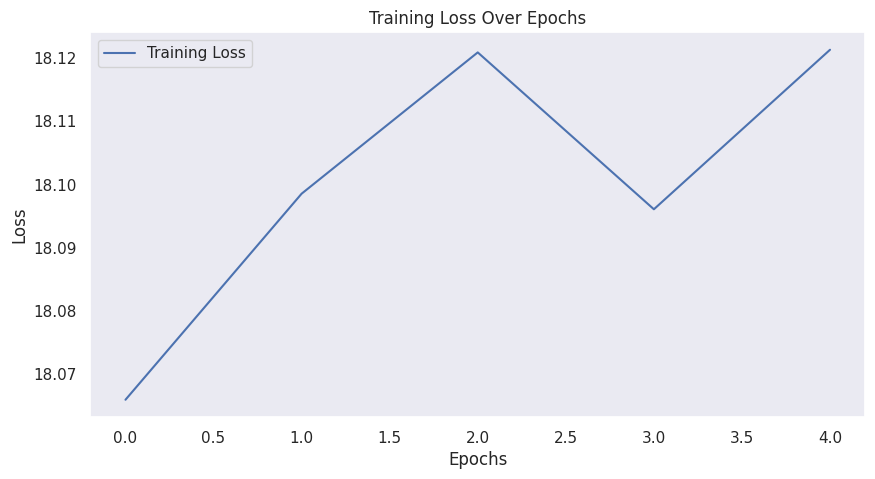

In [ ]:
import matplotlib.pyplot as plt

# Initialize an empty list to store loss values
losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    data_gen = get_data_generator(train_dataset['translation'], LANG_TOKEN_MAPPING, tokenizer, batch_size, max_seq_len)

    for batch_idx, (input_data, target_data) in enumerate(data_gen):
        optimizer.zero_grad()

        # Convert input_data and target_data to torch.LongTensor and move to 'cuda'
        input_data = input_data.long().to('cuda')
        target_data = target_data.long().to('cuda')

        # Ensure that input_data and target_data have the correct shape
        input_data = input_data.view(batch_size, -1)  # Reshape to (batch_size, sequence_length)
        target_data = target_data.view(batch_size, -1)  # Reshape to (batch_size, sequence_length)

        # Generate attention mask
        attention_mask = (input_data != tokenizer.pad_token_id).float().to('cuda')  # 1 for actual tokens, 0 for padding

        # Forward pass
        inputs = {'input_ids': input_data, 'attention_mask': attention_mask}
        outputs = model(**inputs, labels=target_data)
        loss = outputs.loss

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        if (batch_idx + 1) % log_interval == 0:
            avg_loss = total_loss / log_interval
            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {avg_loss:.4f}")
            total_loss = 0.0

    # Append the average loss for the current epoch to the list
    losses.append(avg_loss)

# Plot the loss values after training all epochs
plt.figure(figsize=(10, 5))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()


Manual Testing

In [ ]:
test_sentence = train_dataset['translation'][53]['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'en',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: Downtown Deland events starting after 10 pm this weekend
Truncated input text: <en> Downtown Deland events starting after 10 pm this weekend</s><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
import custom
print("Input: I had about a 30 minute demo just using this new headset")
hinglish_input = input()
output = custom.custom(hinglish_input)
print("Output:", output)

Input: I had about a 30 minute demo just using this new headset
mujhe sirf 30 minute ka demo mila tha , naye headset ka istemaal karne ke liye
Output: मुझे सिर्फ ३० minute का demo मिला था , नये हेडसेट का इस्तमेल करने के लिए


In [ ]:
print("Input: Definitely share your feedback in the comment section.")
hinglish_input = input()
output = custom.custom(hinglish_input)
print("Output:", output)

Input: Definitely share your feedback in the comment section.
apna feedback comment section mein jaroor share kare
Output: अपना feedback comment section में जरूर share करें


In [ ]:
print("Input: So even if it's a big video, I will clearly mention all the products.")
hinglish_input = input()
output = custom.custom(hinglish_input)
print("Output:", output)

Input: So even if it's a big video, I will clearly mention all the products.
bhale hi ye ek bada video ho , mai sabhi products ko clearly mention karunga
Output: भले ही यह एक बड़ा video हो , मैं सभी products को clearly mention करूंगा


In [ ]:
print("Input: I was waiting for my bag.")
hinglish_input = input()
output = custom.custom(hinglish_input)
print("Output:", output)

Input: I was waiting for my bag.
mai apne bag ka wait kar raha tha
Output: मैं अपने bag का wait कर रहा था
